# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

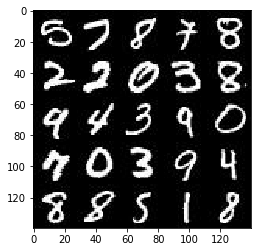

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

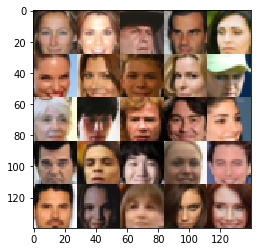

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width  --> 28
    :param image_height: The input image height --> 28
    :param image_channels: The number of image channels --> 3
    :param z_dim: The dimension of Z --> 100
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    tensor_real_imput_img = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    tensor_z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    print(z_dim)
    return (tensor_real_imput_img, tensor_z_data, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

100
Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)--> Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer --> 28, 28, 3
        
        start_dim = 28*2
        kernel_sz = 5
        strides = 2

        
        layer_0 = tf.layers.conv2d(images, start_dim, kernel_sz, strides=strides, padding='same')
        relu_0 = tf.maximum(alpha * layer_0, layer_0)
        #14*14*56
        
        layer_1 = tf.layers.conv2d(relu_0, start_dim*2, kernel_sz, strides=strides, padding='same')
        batchnorm_1 = tf.layers.batch_normalization(layer_1, training=True)
        relu_1 = tf.maximum(alpha * batchnorm_1, batchnorm_1)
        #  7, 7, 112
        
        layer_2 = tf.layers.conv2d(relu_1, start_dim*4, kernel_sz, strides=strides, padding='same')
        batchnorm_2 = tf.layers.batch_normalization(layer_2, training=True)
        relu_2 = tf.maximum(alpha * batchnorm_2, batchnorm_2)
        #4, 4, 224
        
        layer_3 = tf.layers.conv2d(relu_2, start_dim*8, kernel_sz, strides=strides, padding='same')
        batchnorm_3 = tf.layers.batch_normalization(layer_2, training=True)
        relu_2 = tf.maximum(alpha * batchnorm_3, batchnorm_3)
        #4, 4, 224
        
        flatten = tf.reshape(relu_2, (-1, (start_dim*4)*4*4)) # --> (?, 7168)
            
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return (output, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z --> Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
    :param out_channel_dim: The number of channels in the output image --> 5
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        start_dim = 512
        kernel_sz = 5
        strides = 2

        layer_0 = tf.layers.dense(z, 7*7*start_dim)
    
        layer_0 = tf.reshape(layer_0, (-1, 7, 7, start_dim))
        layer_0 = tf.layers.batch_normalization(layer_0, training=is_train)
        # 7, 7, 512 
      
        layer_1 = tf.layers.conv2d_transpose(layer_0, int(start_dim/2), kernel_sz, strides=strides, padding='same')
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        relu_1 = tf.maximum(alpha * layer_1, layer_1)
        # 14, 14, 256
    
        layer_2 = tf.layers.conv2d_transpose(layer_1, int(start_dim/4), kernel_sz, strides=strides, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        relu_2 = tf. maximum(alpha * layer_2, layer_2)
        # 28, 28, 128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, int(start_dim/8), kernel_sz, strides=strides, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        relu_3 = tf. maximum(alpha * layer_3, layer_3)
        # 28, 28, 128

    
        logits = tf.layers.conv2d_transpose(layer_3, out_channel_dim, kernel_sz, strides=strides, padding='same')
        logits = tf.reshape(logits, (-1, 28, 28, out_channel_dim))
        # 28, 28, 5
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    alpha=0.2
    
    #generator with z input
    g_mod = generator(input_z, out_channel_dim, alpha=alpha)
    
    # discriminator with real input and g_mod output
    d_out_real, d_log_real = discriminator(input_real, alpha=alpha)
    d_out_fake, d_log_fake = discriminator(g_mod, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
                                tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_log_real,
                                    labels=tf.ones_like(d_out_real)
                                 ))
    
    d_loss_fake = tf.reduce_mean(
                                tf.nn.sigmoid_cross_entropy_with_logits(
                                logits=d_log_fake,
                                labels=tf.zeros_like(d_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_log_fake,
                                                                 labels=tf.ones_like(d_out_fake)))
    
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer --> 0.9 (eg less than 1)
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    
    #variable generators with shape (3,3), float32
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_op, g_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches,
          data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension --> 100
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data  --> (60000, 28, 28, 1)
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps = 0
    div_by = 20
    n_images = 10
    image_mode="RGB"
    samples=[]
    
    input_real, input_z, lr = model_inputs(data_shape[1], 
                                                      data_shape[2], 
                                                      data_shape[3], 
                                                      z_dim)
    # --> Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32) 
    # Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
    # Tensor("Placeholder_2:0", dtype=float32)
            
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    # --> Tensor("add:0", shape=(), dtype=float32), Tensor("Mean_2:0", shape=(), dtype=float32) 
    
    d_train_op, g_train_op = model_opt(d_loss, g_loss, learning_rate, beta1)
     

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # sample random noise
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # engage optimizers for discriminator and generator
                _ = sess.run(d_train_op, feed_dict={input_real: batch_images,
                                                    input_z: z_batch, 
                                                    lr:learning_rate})
                _ = sess.run(g_train_op, feed_dict={input_real: batch_images,
                                                    input_z: z_batch,
                                                    lr: learning_rate})
        
            
                # get losses for printing every n steps
                if steps % 20 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: z_batch})
                    g_train_loss = g_loss.eval({input_z: z_batch})

                    print("Epoch {}/{} {} steps".format(epoch_i+1, epochs, steps), 
                         "- training losses: "
                         " discriminator: {:.4f}".format(d_train_loss),
                         "| generator {:.4f}".format(g_train_loss))
                    
                    if steps % 100 == 0:
                        if data_shape[3] == 1:
                            image_mode= "L"
                        show_generator_output(sess, n_images, input_z, data_shape[3], image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

100
Epoch 1/2 20 steps - training losses:  discriminator: 0.0500 | generator 3.7076
Epoch 1/2 40 steps - training losses:  discriminator: 1.2980 | generator 1.0363
Epoch 1/2 60 steps - training losses:  discriminator: 0.7684 | generator 0.9506
Epoch 1/2 80 steps - training losses:  discriminator: 0.7885 | generator 2.4413
Epoch 1/2 100 steps - training losses:  discriminator: 0.8312 | generator 0.8510


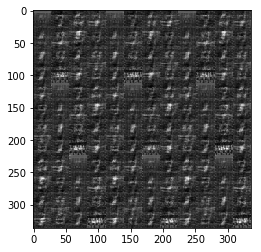

Epoch 1/2 120 steps - training losses:  discriminator: 0.7214 | generator 1.0651
Epoch 1/2 140 steps - training losses:  discriminator: 0.8067 | generator 0.7661
Epoch 1/2 160 steps - training losses:  discriminator: 0.6340 | generator 1.2366
Epoch 1/2 180 steps - training losses:  discriminator: 0.7066 | generator 1.3687
Epoch 1/2 200 steps - training losses:  discriminator: 0.6863 | generator 0.9863


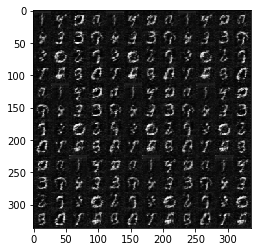

Epoch 1/2 220 steps - training losses:  discriminator: 0.9289 | generator 2.1649
Epoch 1/2 240 steps - training losses:  discriminator: 1.1128 | generator 2.3941
Epoch 1/2 260 steps - training losses:  discriminator: 0.7478 | generator 1.1029
Epoch 1/2 280 steps - training losses:  discriminator: 0.9809 | generator 0.6710
Epoch 1/2 300 steps - training losses:  discriminator: 0.8590 | generator 1.3734


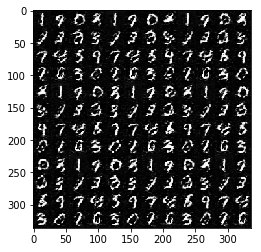

Epoch 1/2 320 steps - training losses:  discriminator: 0.7553 | generator 1.1256
Epoch 1/2 340 steps - training losses:  discriminator: 1.2082 | generator 2.8525
Epoch 1/2 360 steps - training losses:  discriminator: 0.7625 | generator 0.9970
Epoch 1/2 380 steps - training losses:  discriminator: 0.8091 | generator 1.2402
Epoch 1/2 400 steps - training losses:  discriminator: 1.0208 | generator 0.5495


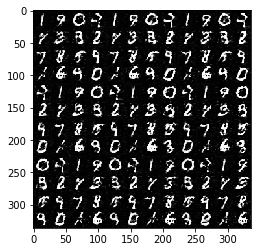

Epoch 1/2 420 steps - training losses:  discriminator: 0.8530 | generator 0.8253
Epoch 1/2 440 steps - training losses:  discriminator: 0.8078 | generator 1.0952
Epoch 1/2 460 steps - training losses:  discriminator: 1.0356 | generator 0.5807
Epoch 1/2 480 steps - training losses:  discriminator: 0.8720 | generator 1.7863
Epoch 1/2 500 steps - training losses:  discriminator: 0.8714 | generator 0.7740


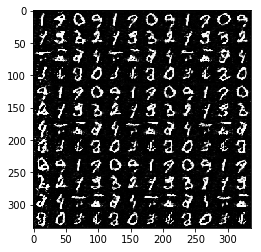

Epoch 1/2 520 steps - training losses:  discriminator: 1.0672 | generator 2.4463
Epoch 1/2 540 steps - training losses:  discriminator: 0.7859 | generator 2.1145
Epoch 1/2 560 steps - training losses:  discriminator: 0.6819 | generator 1.3283
Epoch 1/2 580 steps - training losses:  discriminator: 1.0800 | generator 2.0164
Epoch 1/2 600 steps - training losses:  discriminator: 1.3146 | generator 2.5221


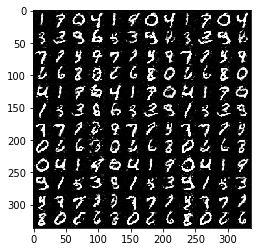

Epoch 1/2 620 steps - training losses:  discriminator: 1.0534 | generator 0.5791
Epoch 1/2 640 steps - training losses:  discriminator: 0.7756 | generator 1.3650
Epoch 1/2 660 steps - training losses:  discriminator: 0.7225 | generator 1.2870
Epoch 1/2 680 steps - training losses:  discriminator: 0.7449 | generator 1.6965
Epoch 1/2 700 steps - training losses:  discriminator: 0.8579 | generator 0.8549


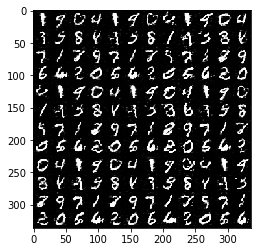

Epoch 1/2 720 steps - training losses:  discriminator: 0.8706 | generator 0.7684
Epoch 1/2 740 steps - training losses:  discriminator: 0.7620 | generator 1.6555
Epoch 1/2 760 steps - training losses:  discriminator: 1.0746 | generator 0.5667
Epoch 1/2 780 steps - training losses:  discriminator: 1.3785 | generator 2.6151
Epoch 1/2 800 steps - training losses:  discriminator: 0.8015 | generator 1.1441


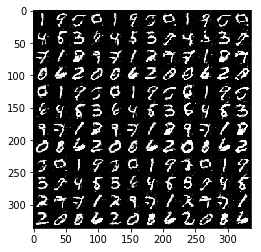

Epoch 1/2 820 steps - training losses:  discriminator: 0.6916 | generator 1.3170
Epoch 1/2 840 steps - training losses:  discriminator: 0.8521 | generator 1.5362
Epoch 2/2 860 steps - training losses:  discriminator: 0.7685 | generator 0.8973
Epoch 2/2 880 steps - training losses:  discriminator: 0.8873 | generator 1.6907
Epoch 2/2 900 steps - training losses:  discriminator: 0.7711 | generator 2.2274


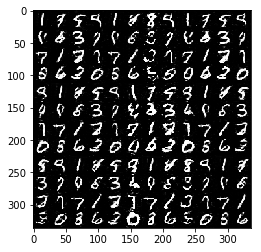

Epoch 2/2 920 steps - training losses:  discriminator: 1.0009 | generator 2.3629
Epoch 2/2 940 steps - training losses:  discriminator: 1.1788 | generator 0.4688
Epoch 2/2 960 steps - training losses:  discriminator: 0.7520 | generator 0.8756
Epoch 2/2 980 steps - training losses:  discriminator: 1.3508 | generator 3.1394
Epoch 2/2 1000 steps - training losses:  discriminator: 0.7091 | generator 1.3474


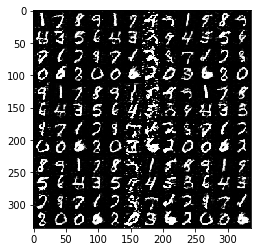

Epoch 2/2 1020 steps - training losses:  discriminator: 0.8853 | generator 0.7002
Epoch 2/2 1040 steps - training losses:  discriminator: 0.6769 | generator 1.9221
Epoch 2/2 1060 steps - training losses:  discriminator: 1.1443 | generator 2.8637
Epoch 2/2 1080 steps - training losses:  discriminator: 0.9950 | generator 2.5350
Epoch 2/2 1100 steps - training losses:  discriminator: 1.3311 | generator 0.4378


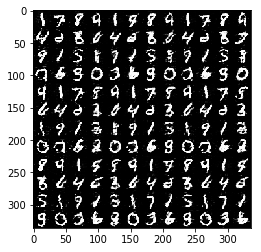

Epoch 2/2 1120 steps - training losses:  discriminator: 0.7690 | generator 1.5918
Epoch 2/2 1140 steps - training losses:  discriminator: 0.6568 | generator 1.7932
Epoch 2/2 1160 steps - training losses:  discriminator: 0.4555 | generator 1.9198
Epoch 2/2 1180 steps - training losses:  discriminator: 0.6448 | generator 1.5918
Epoch 2/2 1200 steps - training losses:  discriminator: 0.6352 | generator 1.0114


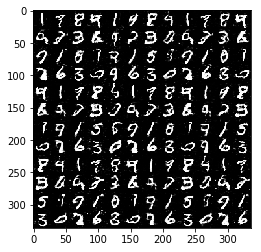

Epoch 2/2 1220 steps - training losses:  discriminator: 0.8213 | generator 0.8160
Epoch 2/2 1240 steps - training losses:  discriminator: 1.0687 | generator 0.5693
Epoch 2/2 1260 steps - training losses:  discriminator: 1.1977 | generator 0.4487
Epoch 2/2 1280 steps - training losses:  discriminator: 0.9163 | generator 0.6678
Epoch 2/2 1300 steps - training losses:  discriminator: 0.6015 | generator 1.8569


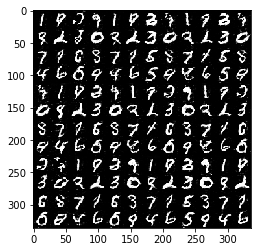

Epoch 2/2 1320 steps - training losses:  discriminator: 0.7003 | generator 0.9357
Epoch 2/2 1340 steps - training losses:  discriminator: 0.6451 | generator 1.9060
Epoch 2/2 1360 steps - training losses:  discriminator: 1.3298 | generator 0.3799
Epoch 2/2 1380 steps - training losses:  discriminator: 0.7550 | generator 2.5644
Epoch 2/2 1400 steps - training losses:  discriminator: 0.8090 | generator 0.8198


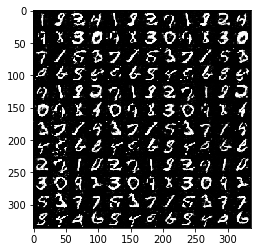

Epoch 2/2 1420 steps - training losses:  discriminator: 0.6476 | generator 1.6275
Epoch 2/2 1440 steps - training losses:  discriminator: 0.5461 | generator 1.5772
Epoch 2/2 1460 steps - training losses:  discriminator: 0.5077 | generator 1.5377
Epoch 2/2 1480 steps - training losses:  discriminator: 0.5932 | generator 1.2284
Epoch 2/2 1500 steps - training losses:  discriminator: 0.4466 | generator 1.4295


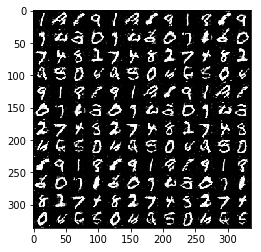

Epoch 2/2 1520 steps - training losses:  discriminator: 0.6839 | generator 1.1879
Epoch 2/2 1540 steps - training losses:  discriminator: 0.6764 | generator 3.1576
Epoch 2/2 1560 steps - training losses:  discriminator: 0.4905 | generator 1.3634
Epoch 2/2 1580 steps - training losses:  discriminator: 0.4489 | generator 2.0467
Epoch 2/2 1600 steps - training losses:  discriminator: 0.5211 | generator 2.0114


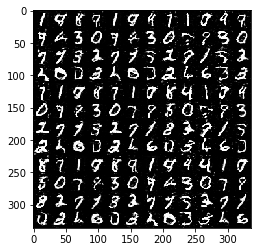

Epoch 2/2 1620 steps - training losses:  discriminator: 0.8321 | generator 0.7960
Epoch 2/2 1640 steps - training losses:  discriminator: 0.4206 | generator 1.5673
Epoch 2/2 1660 steps - training losses:  discriminator: 0.4471 | generator 2.2000
Epoch 2/2 1680 steps - training losses:  discriminator: 0.4545 | generator 1.3035
Epoch 2/2 1700 steps - training losses:  discriminator: 0.4937 | generator 1.7765


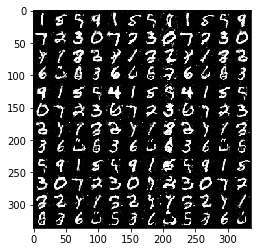

In [14]:
batch_size = 70 #75 #128 #64 #75
z_dim = 100 #90
learning_rate = 0.0005
beta1 = 0.5 #0.5

#Epoch 2/2 920 steps - training losses:  discriminator: 0.8415 | generator 4.2866
#Epoch 2/2 1600 steps - training losses:  discriminator: 0.4646 | generator 2.1614

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

100
Epoch 1/1 20 steps - training losses:  discriminator: 0.0275 | generator 5.5546
Epoch 1/1 40 steps - training losses:  discriminator: 0.0482 | generator 4.0023
Epoch 1/1 60 steps - training losses:  discriminator: 1.4587 | generator 0.6212
Epoch 1/1 80 steps - training losses:  discriminator: 1.8536 | generator 0.3300
Epoch 1/1 100 steps - training losses:  discriminator: 0.5243 | generator 1.3410


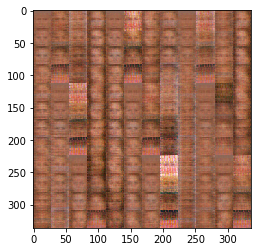

Epoch 1/1 120 steps - training losses:  discriminator: 0.5538 | generator 7.5898
Epoch 1/1 140 steps - training losses:  discriminator: 0.3810 | generator 1.7353
Epoch 1/1 160 steps - training losses:  discriminator: 0.3323 | generator 2.4022
Epoch 1/1 180 steps - training losses:  discriminator: 3.0744 | generator 3.2157
Epoch 1/1 200 steps - training losses:  discriminator: 0.2256 | generator 4.4108


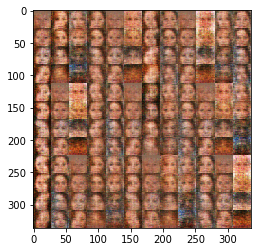

Epoch 1/1 220 steps - training losses:  discriminator: 0.3131 | generator 3.3329
Epoch 1/1 240 steps - training losses:  discriminator: 0.8861 | generator 0.7035
Epoch 1/1 260 steps - training losses:  discriminator: 0.0998 | generator 4.8844
Epoch 1/1 280 steps - training losses:  discriminator: 1.6898 | generator 2.4623
Epoch 1/1 300 steps - training losses:  discriminator: 0.8478 | generator 0.7785


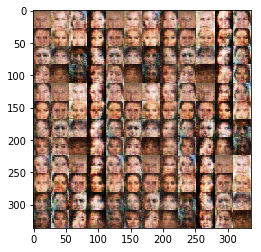

Epoch 1/1 320 steps - training losses:  discriminator: 0.5073 | generator 1.3015
Epoch 1/1 340 steps - training losses:  discriminator: 0.6225 | generator 3.4445
Epoch 1/1 360 steps - training losses:  discriminator: 0.2188 | generator 2.3342
Epoch 1/1 380 steps - training losses:  discriminator: 0.3040 | generator 2.6637
Epoch 1/1 400 steps - training losses:  discriminator: 0.1519 | generator 3.4131


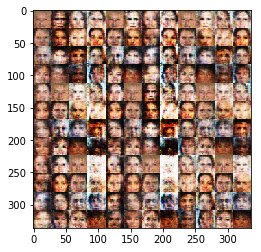

Epoch 1/1 420 steps - training losses:  discriminator: 0.1842 | generator 2.7459
Epoch 1/1 440 steps - training losses:  discriminator: 0.1648 | generator 2.8367
Epoch 1/1 460 steps - training losses:  discriminator: 0.1879 | generator 2.3456
Epoch 1/1 480 steps - training losses:  discriminator: 0.1568 | generator 2.5907
Epoch 1/1 500 steps - training losses:  discriminator: 0.4020 | generator 1.4288


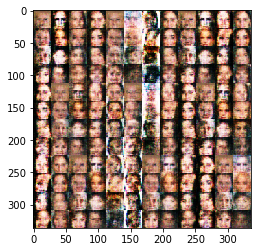

Epoch 1/1 520 steps - training losses:  discriminator: 0.0716 | generator 7.0634
Epoch 1/1 540 steps - training losses:  discriminator: 0.1313 | generator 2.5439
Epoch 1/1 560 steps - training losses:  discriminator: 0.9391 | generator 0.6745
Epoch 1/1 580 steps - training losses:  discriminator: 0.2387 | generator 3.9696
Epoch 1/1 600 steps - training losses:  discriminator: 0.2168 | generator 2.3303


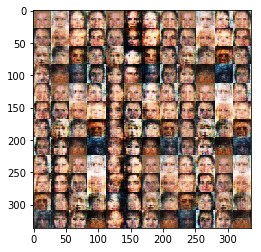

Epoch 1/1 620 steps - training losses:  discriminator: 0.1400 | generator 3.5189
Epoch 1/1 640 steps - training losses:  discriminator: 0.3100 | generator 1.6695
Epoch 1/1 660 steps - training losses:  discriminator: 0.0473 | generator 5.9863
Epoch 1/1 680 steps - training losses:  discriminator: 0.0464 | generator 5.1143
Epoch 1/1 700 steps - training losses:  discriminator: 1.3405 | generator 0.3866


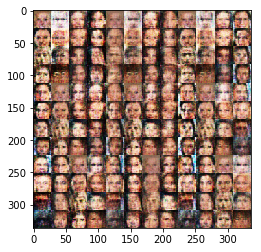

Epoch 1/1 720 steps - training losses:  discriminator: 0.2249 | generator 1.9579
Epoch 1/1 740 steps - training losses:  discriminator: 0.1461 | generator 3.0507
Epoch 1/1 760 steps - training losses:  discriminator: 0.2773 | generator 1.6972
Epoch 1/1 780 steps - training losses:  discriminator: 0.8055 | generator 4.2969
Epoch 1/1 800 steps - training losses:  discriminator: 0.1194 | generator 6.0575


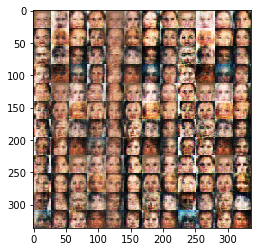

Epoch 1/1 820 steps - training losses:  discriminator: 0.1318 | generator 6.9961
Epoch 1/1 840 steps - training losses:  discriminator: 2.0408 | generator 0.1822
Epoch 1/1 860 steps - training losses:  discriminator: 0.1385 | generator 3.7699
Epoch 1/1 880 steps - training losses:  discriminator: 0.0728 | generator 5.3620
Epoch 1/1 900 steps - training losses:  discriminator: 0.0646 | generator 7.1587


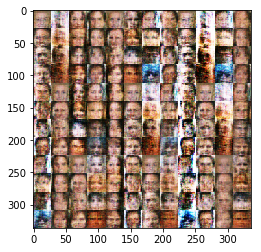

Epoch 1/1 920 steps - training losses:  discriminator: 0.0838 | generator 8.7716
Epoch 1/1 940 steps - training losses:  discriminator: 0.6608 | generator 0.9944
Epoch 1/1 960 steps - training losses:  discriminator: 0.2028 | generator 2.3716
Epoch 1/1 980 steps - training losses:  discriminator: 0.2416 | generator 1.9663
Epoch 1/1 1000 steps - training losses:  discriminator: 0.6380 | generator 0.9974


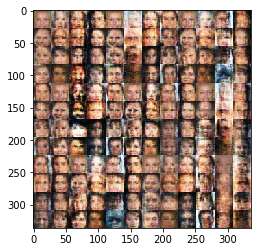

Epoch 1/1 1020 steps - training losses:  discriminator: 0.1106 | generator 2.7241
Epoch 1/1 1040 steps - training losses:  discriminator: 0.2729 | generator 1.7980
Epoch 1/1 1060 steps - training losses:  discriminator: 0.3729 | generator 1.4704
Epoch 1/1 1080 steps - training losses:  discriminator: 0.0564 | generator 4.2896
Epoch 1/1 1100 steps - training losses:  discriminator: 0.0680 | generator 3.4423


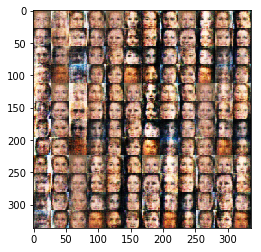

Epoch 1/1 1120 steps - training losses:  discriminator: 0.0384 | generator 5.3125
Epoch 1/1 1140 steps - training losses:  discriminator: 0.0343 | generator 6.5533
Epoch 1/1 1160 steps - training losses:  discriminator: 0.0460 | generator 9.6945
Epoch 1/1 1180 steps - training losses:  discriminator: 0.0282 | generator 5.6699
Epoch 1/1 1200 steps - training losses:  discriminator: 0.0401 | generator 7.7414


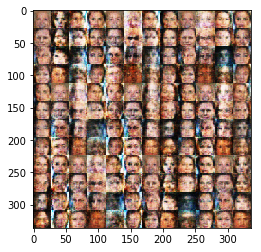

Epoch 1/1 1220 steps - training losses:  discriminator: 0.0319 | generator 5.0940
Epoch 1/1 1240 steps - training losses:  discriminator: 1.4490 | generator 0.4115
Epoch 1/1 1260 steps - training losses:  discriminator: 0.6883 | generator 2.0520
Epoch 1/1 1280 steps - training losses:  discriminator: 0.5647 | generator 1.0829
Epoch 1/1 1300 steps - training losses:  discriminator: 1.1306 | generator 3.8663


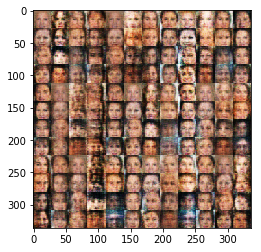

Epoch 1/1 1320 steps - training losses:  discriminator: 0.6800 | generator 1.5236
Epoch 1/1 1340 steps - training losses:  discriminator: 0.3715 | generator 1.6658
Epoch 1/1 1360 steps - training losses:  discriminator: 0.3714 | generator 1.6832
Epoch 1/1 1380 steps - training losses:  discriminator: 0.3481 | generator 2.2979
Epoch 1/1 1400 steps - training losses:  discriminator: 0.5865 | generator 3.2186


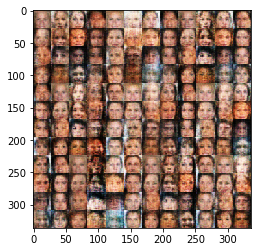

Epoch 1/1 1420 steps - training losses:  discriminator: 0.3297 | generator 2.2453
Epoch 1/1 1440 steps - training losses:  discriminator: 0.7544 | generator 3.5172
Epoch 1/1 1460 steps - training losses:  discriminator: 0.3413 | generator 1.7136
Epoch 1/1 1480 steps - training losses:  discriminator: 0.4117 | generator 1.4012
Epoch 1/1 1500 steps - training losses:  discriminator: 0.3449 | generator 1.8736


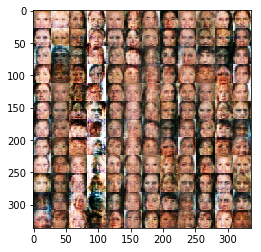

Epoch 1/1 1520 steps - training losses:  discriminator: 0.4112 | generator 1.5096
Epoch 1/1 1540 steps - training losses:  discriminator: 0.6527 | generator 3.3763
Epoch 1/1 1560 steps - training losses:  discriminator: 0.8415 | generator 0.7496
Epoch 1/1 1580 steps - training losses:  discriminator: 0.3467 | generator 1.6460


In [15]:
batch_size = 128 #64 #100 #64 #128
z_dim = 100 #100 #110
learning_rate =  0.0005 #0.005 ##0.0005
beta1 = 0.4 #0.4

#Epoch 1/1 1580 steps - training losses:  discriminator: 0.7630 | generator 5.3722 - stopped earlly
#Epoch 1/1 3000 steps - training losses:  discriminator: 0.1074 | generator 6.1110
#Epoch 1/1 2360 steps - training losses:  discriminator: 233.2417 | generator 613.2948 - stopped early
#Epoch 1/1 540 steps - training losses:  discriminator: 4.4537 | generator 59.3181 - stopped early


#Epoch 1/1 2020 steps - training losses:  discriminator: 0.6833 | generator 0.9854
#Epoch 1/1 2000 steps - training losses:  discriminator: 0.7036 | generator 1.9916
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.